In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

In [97]:
!pip install -U statsmodels

In [98]:
!wget -nc https://lazyprogrammer.me/course_files/sp500sub.csv

File ‘sp500sub.csv’ already there; not retrieving.



In [99]:
!head sp500sub.csv

Date,Open,High,Low,Close,Adj Close,Volume,Name
2010-01-04,9.220000267028807,9.510000228881836,9.170000076293944,9.5,9.5,1865400.0,INCY
2010-01-05,9.510000228881836,10.289999961853027,9.449999809265137,10.270000457763672,10.270000457763672,7608900.0,INCY
2010-01-06,10.380000114440918,11.09000015258789,10.350000381469727,11.0,11.0,8046700.0,INCY
2010-01-07,11.0,11.0600004196167,10.619999885559082,10.81999969482422,10.81999969482422,3680300.0,INCY
2010-01-08,10.81999969482422,11.0,10.75,10.9399995803833,10.9399995803833,1529300.0,INCY
2010-01-11,10.960000038146973,11.239999771118164,10.880000114440918,11.09000015258789,11.09000015258789,2280600.0,INCY
2010-01-12,10.989999771118164,11.0,10.34000015258789,10.359999656677246,10.359999656677246,4204600.0,INCY
2010-01-13,10.359999656677246,10.460000038146973,10.039999961853027,10.329999923706056,10.329999923706056,2134900.0,INCY
2010-01-14,10.3100004196167,10.390000343322754,10.079999923706056,10.15999984741211,10.15999984741211,2889600.0,INCY

In [100]:
df = pd.read_csv('sp500sub.csv', index_col='Date', parse_dates=True)

In [101]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2010-01-04,9.22,9.51,9.17,9.50,9.50,1865400.0,INCY
2010-01-05,9.51,10.29,9.45,10.27,10.27,7608900.0,INCY
2010-01-06,10.38,11.09,10.35,11.00,11.00,8046700.0,INCY
2010-01-07,11.00,11.06,10.62,10.82,10.82,3680300.0,INCY
2010-01-08,10.82,11.00,10.75,10.94,10.94,1529300.0,INCY


In [102]:
goog = df[df['Name'] == 'GOOG'][['Close']].copy()

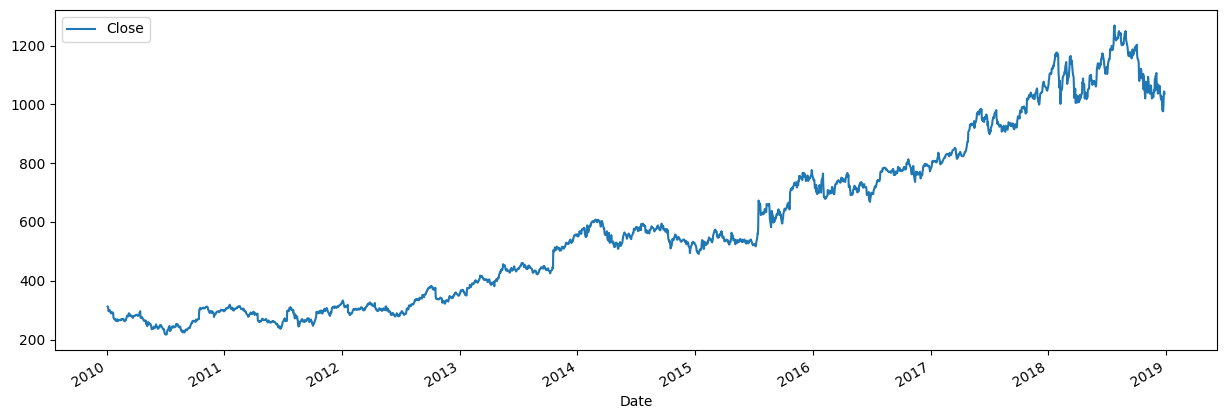

In [103]:
goog.plot(figsize=(15, 5));

In [104]:
goog['LogClose'] = np.log(goog['Close'])

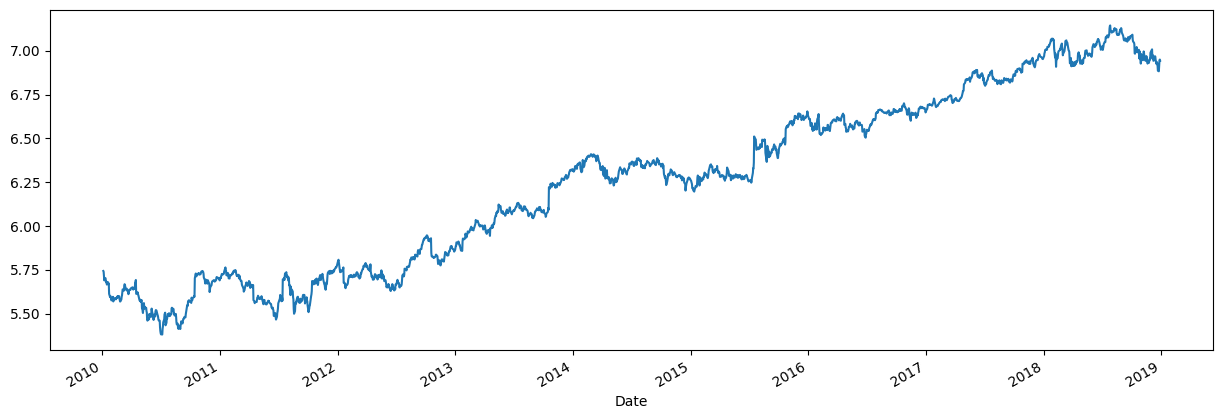

In [105]:
goog['LogClose'].plot(figsize=(15, 5));

In [106]:
# goog.index.freq = 'B'

In [107]:
Ntest = 30
train = goog.iloc[:-Ntest]
test = goog.iloc[-Ntest:]

In [108]:
# boolean series to index df rows
train_idx = goog.index <= train.index[-1]
test_idx = goog.index > train.index[-1]

In [109]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [110]:
hw = ExponentialSmoothing(
    train['LogClose'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal=None)
res_hw = hw.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [111]:
goog.loc[train_idx, 'HoltWintersTrain'] = res_hw.fittedvalues

In [112]:
goog.loc[test_idx, 'HoltWintersTest'] = res_hw.forecast(Ntest).to_numpy()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


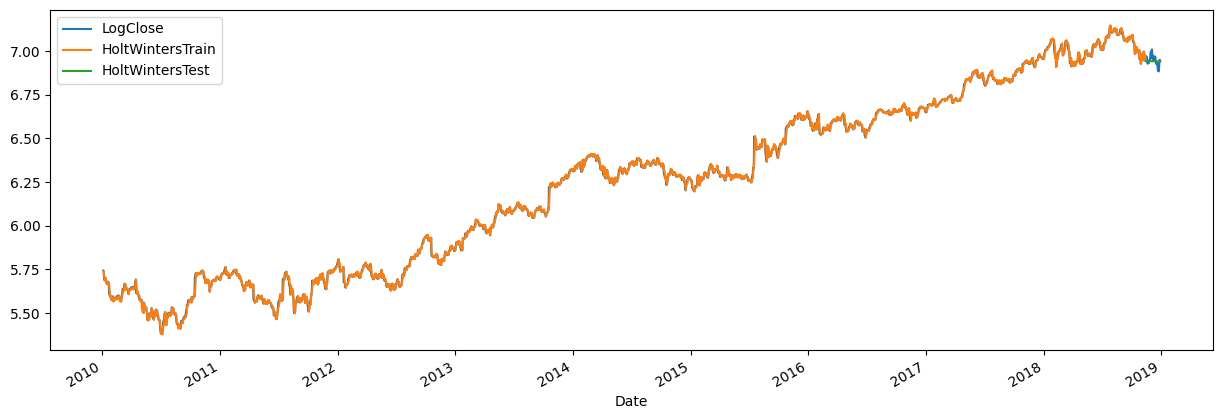

In [113]:
goog[['LogClose', 'HoltWintersTrain', 'HoltWintersTest']].plot(figsize=(15, 5));

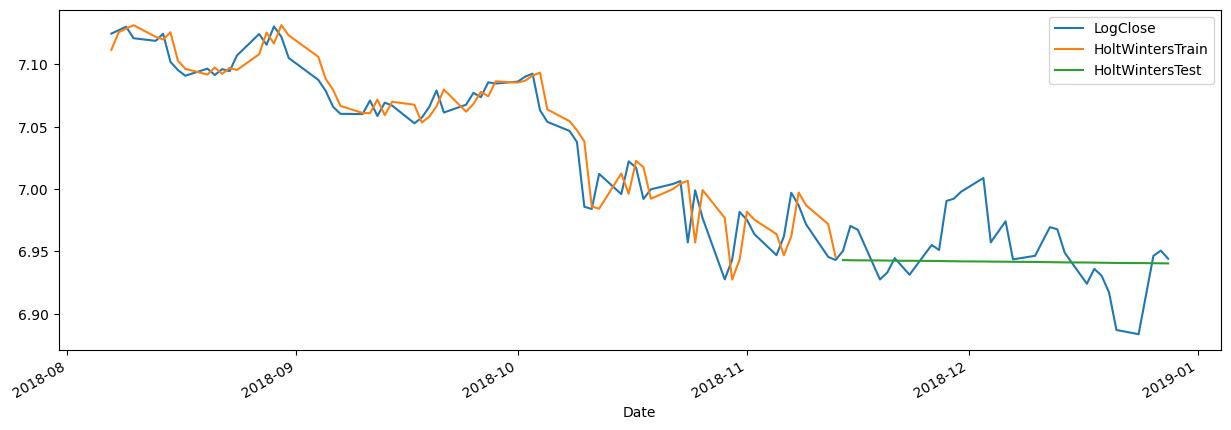

In [114]:
cols = ['LogClose', 'HoltWintersTrain', 'HoltWintersTest']
goog.iloc[-100:][cols].plot(figsize=(15, 5));

In [115]:
goog.loc[test_idx, 'Naive'] = train.iloc[-1]['LogClose'] # naive forecast for test data is the last log close in train data

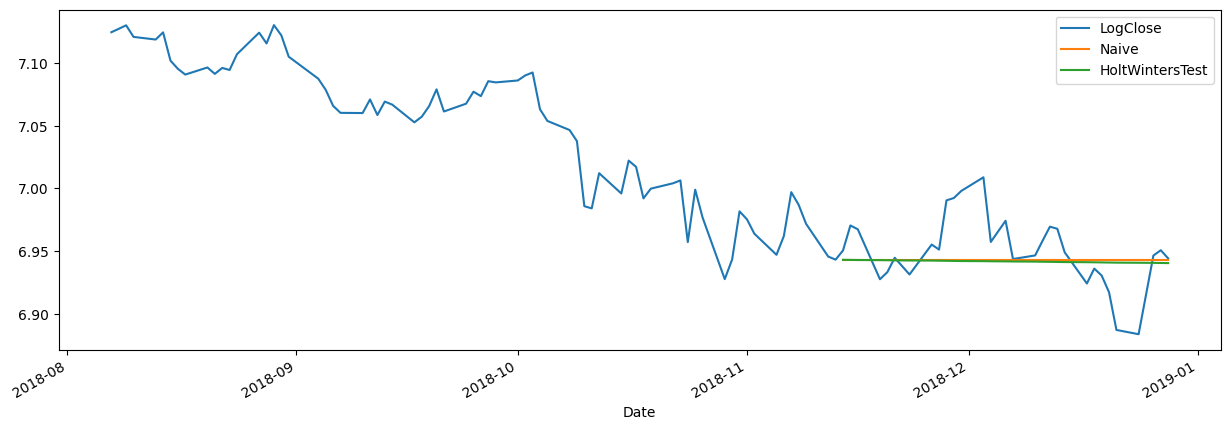

In [116]:
goog.iloc[-100:][['LogClose', 'Naive', 'HoltWintersTest']].plot(figsize=(15, 5));

In [117]:
r2_score(goog.loc[test_idx, 'LogClose'], goog.loc[test_idx, 'Naive'])

-0.06454209862026317

In [118]:
r2_score(goog.loc[test_idx, 'LogClose'], goog.loc[test_idx, 'HoltWintersTest'])

-0.07182717302032238